# Threshold statistics

Original file is (threshold_stats-Copy1.ipynb)

File is designed to run interactively!!

4 runs required 
2 for bias-input for ssp126 and ssp370
2 for bias-output for ssp126 and ssp370


The file is being modified to read in various GWLs, scenarios and RCMs

read in the threshold data all the simulations for the various GWLs and compute
median value from all the RCMs

additional file with the all the RCM values for each GWL is also written to enable calculating the 10 and 90% values for any region


In [1]:
import sys
import os

import intake
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import glob
import pathlib
import traceback
from datetime import datetime
import pandas as pd 
from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)
from dask.distributed import Client

# Needed for the GWL code
from importlib import reload
# adding folder to the system path
sys.path.insert(0, '/g/data/xv83/rxm599/acs/gwls')

import gwl

In [2]:
# Start Cluster 
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

client = Client()
client

2025-03-14 12:05:12,895 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-03-14 12:05:12,899 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-03-14 12:05:12,928 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0248.gadi.nci.org.au/36414/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0248.gadi.nci.org.au/36414/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45683,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0248.gadi.nci.org.au/36414/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:32837,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0248.gadi.nci.org.au/36414/proxy/34471/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38735,


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def extract_model_info(filepath):
    filename = filepath.split('/')[-1]  # Get the filename from the full path
    mm = filename.split('.')[:-1]  # Remove the file extension
    model_name = '.'.join(mm)
    parts = model_name.split('_')  # Split filename by underscores
    extension = filename.split('.')[-1]  # Get the extension
#    print(parts)
    pathway = parts[3]  # Extract model (e.g., ssp370)
    GCM=parts[2]
    version=parts[5]
    RCM=parts[1]
    GWL=parts[8]
#    ensemble = parts[4]  # Extract ensemble (e.g., r1i1p1f1)
    
    return model_name ,RCM, GCM, pathway, version, GWL

## Revised Code
Current code uses GCM and RCM to determine how to structure the data into model, GWL and thresholds

Current thinking is to make a separate file for ssp126 and ssp370 for bias input and bias output (4 files) 

In [18]:
# List of periods and variables
periods = ['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0']
base_period = 'GW1p2'

kind='ssp126'
kind='ssp370'

# Input and output directories
data_path = '/g/data/ia39/ncra/fire/'
data_path = '/g/data/ia39/ncra/fire/bias-input/threshold/'
data_path = '/scratch/xv83/rxm599/tmp/'
#output
outdir='/g/data/ia39/ncra/fire/bias-input/threshold_summary/'
outdir='/g/data/ia39/ncra/fire/bias-output/threshold_summary/'
mRuns = sorted(glob.glob(data_path + '*'+kind+'*threshold.nc'))
print(len(mRuns))

84


In [19]:
sys.path.insert(0, '/g/data/xv83/rxm599/acs/hazard_fire/')
import ffdi_threshold_batch as rjm
import ffdi_batch as rjm2

In [20]:
for mr in mRuns[70:]:
    mm=extract_model_info(mr)
    print(mm)


('AUST-05i_NSW-Government_MPI-ESM1-2-HR_ssp370_r1i1p1f1_NARCliM2-0-WRF412R3_v1-r1-ACS-QME-BARRAR2-1980-2022_day_GWL2.0_ffdi_threshold', 'NSW-Government', 'MPI-ESM1-2-HR', 'ssp370', 'NARCliM2-0-WRF412R3', 'GWL2.0')
('AUST-05i_NSW-Government_MPI-ESM1-2-HR_ssp370_r1i1p1f1_NARCliM2-0-WRF412R3_v1-r1-ACS-QME-BARRAR2-1980-2022_day_GWL3.0_ffdi_threshold', 'NSW-Government', 'MPI-ESM1-2-HR', 'ssp370', 'NARCliM2-0-WRF412R3', 'GWL3.0')
('AUST-05i_NSW-Government_MPI-ESM1-2-HR_ssp370_r1i1p1f1_NARCliM2-0-WRF412R5_v1-r1-ACS-QME-BARRAR2-1980-2022_day_GWL1.2_ffdi_threshold', 'NSW-Government', 'MPI-ESM1-2-HR', 'ssp370', 'NARCliM2-0-WRF412R5', 'GWL1.2')
('AUST-05i_NSW-Government_MPI-ESM1-2-HR_ssp370_r1i1p1f1_NARCliM2-0-WRF412R5_v1-r1-ACS-QME-BARRAR2-1980-2022_day_GWL1.5_ffdi_threshold', 'NSW-Government', 'MPI-ESM1-2-HR', 'ssp370', 'NARCliM2-0-WRF412R5', 'GWL1.5')
('AUST-05i_NSW-Government_MPI-ESM1-2-HR_ssp370_r1i1p1f1_NARCliM2-0-WRF412R5_v1-r1-ACS-QME-BARRAR2-1980-2022_day_GWL2.0_ffdi_threshold', 'NSW-Gov

In [21]:
%%time
nmodel=0
for count, mm in enumerate(mRuns):
    ds=xr.open_dataset(mm)
    mname,RCM,GCM,ssp,version,Gwl=extract_model_info(mm)
    gg=RCM+'_'+GCM+'_'+version
    print(gg,version)
    d1=ds.expand_dims(GCM=[gg],GWL=[Gwl])
    if count == 0:
        dall1=d1
        GCMo=GCM+version
    else:
        if GCM+version == GCMo:
            dall1 = xr.combine_by_coords([dall1,d1])
        else:
            print(f'nmodel= {nmodel}',GCM)
            if nmodel == 0 :
                da3=dall1
            if nmodel >= 1 :
               da3=xr.combine_by_coords([da3,dall1]) 
            dall1=d1
            GCMo=GCM+version
            nmodel=nmodel+1

print(nmodel,'last')
da3=xr.combine_by_coords([da3,dall1]) 
da3
print(len(da3['GCM']), len(da3['GWL']))
dall=da3

BOM_ACCESS-CM2_BARPA-R BARPA-R
BOM_ACCESS-CM2_BARPA-R BARPA-R
BOM_ACCESS-CM2_BARPA-R BARPA-R
BOM_ACCESS-CM2_BARPA-R BARPA-R
BOM_CESM2_BARPA-R BARPA-R
nmodel= 0 CESM2
BOM_CESM2_BARPA-R BARPA-R
BOM_CESM2_BARPA-R BARPA-R
BOM_CESM2_BARPA-R BARPA-R
BOM_CMCC-ESM2_BARPA-R BARPA-R
nmodel= 1 CMCC-ESM2
BOM_CMCC-ESM2_BARPA-R BARPA-R
BOM_CMCC-ESM2_BARPA-R BARPA-R
BOM_CMCC-ESM2_BARPA-R BARPA-R
BOM_EC-Earth3_BARPA-R BARPA-R
nmodel= 2 EC-Earth3
BOM_EC-Earth3_BARPA-R BARPA-R
BOM_EC-Earth3_BARPA-R BARPA-R
BOM_EC-Earth3_BARPA-R BARPA-R
BOM_MPI-ESM1-2-HR_BARPA-R BARPA-R
nmodel= 3 MPI-ESM1-2-HR
BOM_MPI-ESM1-2-HR_BARPA-R BARPA-R
BOM_MPI-ESM1-2-HR_BARPA-R BARPA-R
BOM_MPI-ESM1-2-HR_BARPA-R BARPA-R
BOM_NorESM2-MM_BARPA-R BARPA-R
nmodel= 4 NorESM2-MM
BOM_NorESM2-MM_BARPA-R BARPA-R
BOM_NorESM2-MM_BARPA-R BARPA-R
BOM_NorESM2-MM_BARPA-R BARPA-R
CSIRO_ACCESS-CM2_CCAM-v2203-SN CCAM-v2203-SN
nmodel= 5 ACCESS-CM2
CSIRO_ACCESS-CM2_CCAM-v2203-SN CCAM-v2203-SN
CSIRO_ACCESS-CM2_CCAM-v2203-SN CCAM-v2203-SN
CSIRO_ACCESS-CM

In [22]:
#da3=xr.combine_by_coords([da3,dall1]) 
#da3
dall

<xarray.Dataset> Size: 2GB
Dimensions:  (GCM: 21, GWL: 4, lat: 691, lon: 886)
Coordinates:
  * GCM      (GCM) object 168B 'BOM_ACCESS-CM2_BARPA-R' ... 'NSW-Government_N...
  * GWL      (GWL) object 32B 'GWL1.2' 'GWL1.5' 'GWL2.0' 'GWL3.0'
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Data variables:
    days50   (GCM, GWL, lat, lon) float64 411MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days75   (GCM, GWL, lat, lon) float64 411MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days100  (GCM, GWL, lat, lon) float64 411MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days25   (GCM, GWL, lat, lon) float64 411MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [23]:
# compute maximum value for each model and GWL value
# nan values reflect the fact the model does not reach that GWL
dall.days50[:,:,:,:].max(axis=(2,3)).values

array([[147.15, 152.  , 147.55, 167.5 ],
       [140.85, 143.75, 151.5 , 166.3 ],
       [131.5 , 138.3 , 156.2 , 162.8 ],
       [134.9 , 132.1 , 140.45, 142.1 ],
       [148.  , 157.1 , 162.35, 166.4 ],
       [164.2 , 178.15, 178.35, 195.35],
       [154.65, 168.15, 166.15, 174.2 ],
       [183.  , 201.3 , 235.  , 252.55],
       [150.  , 158.75, 167.8 , 178.05],
       [132.6 , 156.9 , 174.45, 170.  ],
       [140.95, 136.75, 150.95, 159.2 ],
       [148.1 , 134.6 , 136.7 , 155.55],
       [178.05, 180.45, 177.25, 191.25],
       [153.6 , 161.3 , 185.75, 202.25],
       [160.45, 173.2 , 196.85, 210.4 ],
       [135.  , 135.65, 132.35, 140.5 ],
       [137.55, 138.5 , 135.25, 138.35],
       [141.75, 159.7 , 158.6 , 177.9 ],
       [148.8 , 158.  , 160.  , 183.45],
       [172.55, 170.4 , 180.05, 191.5 ],
       [169.1 , 170.9 , 172.7 , 188.85]])

In [24]:
# compute difference from GWL1.2 
ddif100=dall.days100[:,:,:,:]-dall.days100[:,0,:,:]
ddif75=dall.days75[:,:,:,:]-dall.days75[:,0,:,:]
ddif50=dall.days50[:,:,:,:]-dall.days50[:,0,:,:]
ddif25=dall.days25[:,:,:,:]-dall.days25[:,0,:,:]
print(ddif50[:,:,:,:].max(axis=(2,3)).values)

[[ 0.   12.65 15.05 39.55]
 [ 0.   14.6  19.5  34.7 ]
 [ 0.   15.35 31.85 42.45]
 [ 0.    5.5  11.7  24.5 ]
 [ 0.   17.5  24.95 37.55]
 [ 0.   19.6  29.85 41.85]
 [ 0.   14.75 17.   38.65]
 [ 0.   24.   62.45 82.25]
 [ 0.   13.05 24.2  34.05]
 [ 0.   39.1  49.4  43.  ]
 [ 0.    8.   16.65 22.9 ]
 [ 0.    5.1  13.9  18.6 ]
 [ 0.   16.9  28.55 38.1 ]
 [ 0.   14.55 44.3  58.7 ]
 [ 0.   15.85 42.5  53.4 ]
 [ 0.    9.   16.75 34.45]
 [ 0.    9.95 16.25 30.45]
 [ 0.   26.1  25.4  46.75]
 [ 0.   13.75 22.7  42.45]
 [ 0.   21.5  34.7  48.1 ]
 [ 0.   19.   35.5  45.1 ]]


In [25]:
%%time
# write out the median value from all the RCMs for GWL1.2
dall.days100[:,0,:,:].to_netcdf(outdir+kind+'_GWL1p2_threshold_all_100.nc')
dall.days75[:,0,:,:].to_netcdf(outdir+kind+'_GWL1p2_threshold_all_75.nc')
dall.days50[:,0,:,:].to_netcdf(outdir+kind+'_GWL1p2_threshold_all_50.nc')
dall.days25[:,0,:,:].to_netcdf(outdir+kind+'_GWL1p2_threshold_all_25.nc')
dall.days100[:,0,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWL1p2_threshold_100.nc')
dall.days75[:,0,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWL1p2_threshold_75.nc')
dall.days50[:,0,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWL1p2_threshold_50.nc')
dall.days25[:,0,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWL1p2_threshold_25.nc')

CPU times: user 1.04 s, sys: 745 ms, total: 1.79 s
Wall time: 1.86 s


In [31]:
%%time
# write out the median value from all the RCMs for all GWLs
dall.days100[:,:,:,:].to_netcdf(outdir+kind+'_GWLs_threshold_all_100.nc')
dall.days75[:,:,:,:].to_netcdf(outdir+kind+'_GWLs_threshold_all_75.nc')
dall.days50[:,:,:,:].to_netcdf(outdir+kind+'_GWLs_threshold_all_50.nc')
dall.days25[:,:,:,:].to_netcdf(outdir+kind+'_GWLs_threshold_all_25.nc')
dall.days100[:,:,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWLs_threshold_100.nc')
dall.days75[:,:,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWLs_threshold_75.nc')
dall.days50[:,:,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWLs_threshold_50.nc')
dall.days25[:,:,:,:].median(axis=(0)).to_netcdf(outdir+kind+'_GWLs_threshold_25.nc')

CPU times: user 2.43 s, sys: 2.23 s, total: 4.66 s
Wall time: 4.07 s


In [32]:
%%time
# write out the change in thresholds from GWL1.2 for each RCM
ddif100.to_netcdf(outdir+kind+'_change_threshold_all_100.nc')
ddif75.to_netcdf(outdir+kind+'_change_threshold_all_75.nc')
ddif50.to_netcdf(outdir+kind+'_change_threshold_all_50.nc')
ddif25.to_netcdf(outdir+kind+'_change_threshold_all_25.nc')
# write out the median change in thresholds from GWL1.2 from all RCMs
ddif100.median(axis=(0)).to_netcdf(outdir+kind+'_change_threshold_100.nc')
ddif75.median(axis=(0)).to_netcdf(outdir+kind+'_change_threshold_75.nc')
ddif50.median(axis=(0)).to_netcdf(outdir+kind+'_change_threshold_50.nc')
ddif25.median(axis=(0)).to_netcdf(outdir+kind+'_change_threshold_25.nc')

CPU times: user 2.22 s, sys: 2.09 s, total: 4.31 s
Wall time: 3.64 s


##  Example Plot

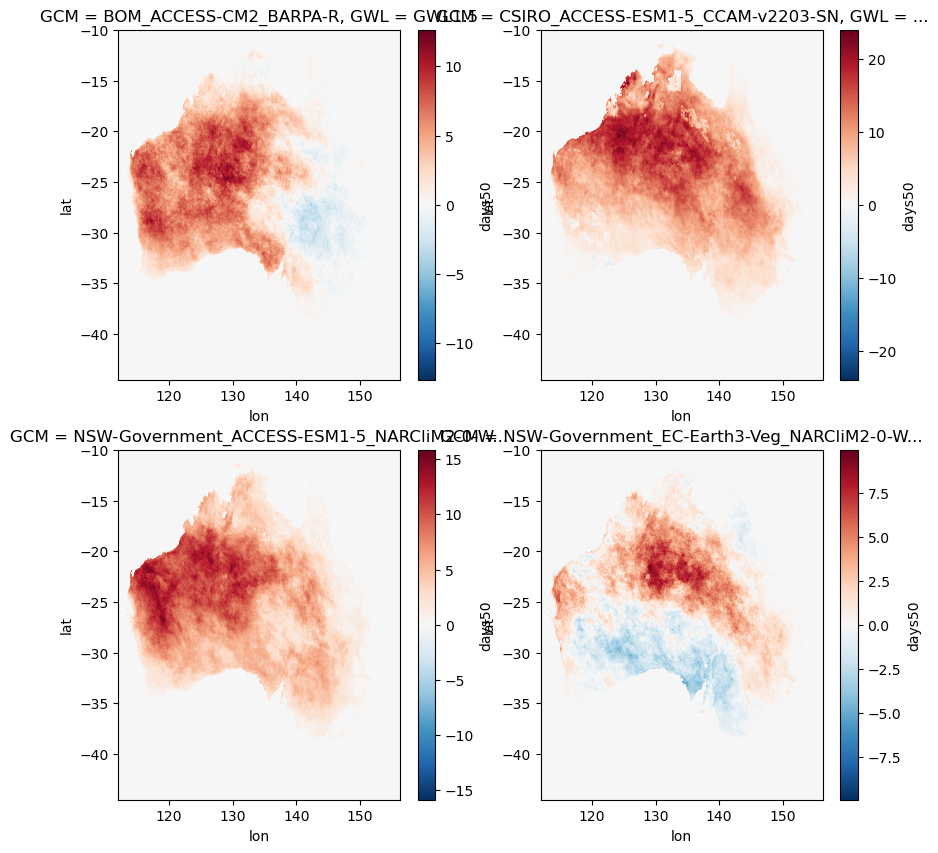

In [33]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1); ddif50[0,1,:].plot()
plt.subplot(2,2,2); ddif50[7,1,:].plot()
plt.subplot(2,2,3); ddif50[14,1,:].plot()
plt.subplot(2,2,4); ddif50[16,1,:].plot()

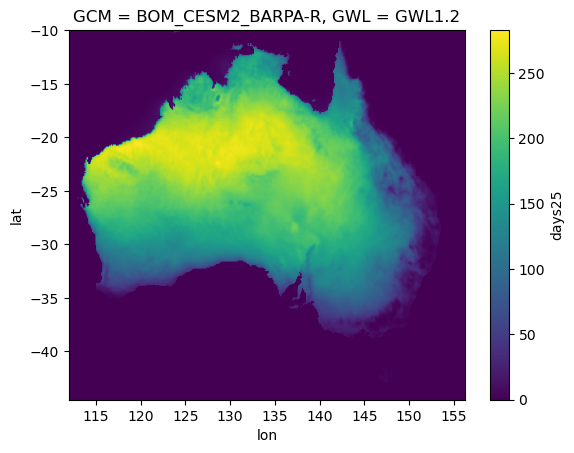

In [34]:
dall.days25[1,0,:].plot()

In [35]:
ddif100['GWL']

<xarray.DataArray 'GWL' (GWL: 4)> Size: 32B
array(['GWL1.2', 'GWL1.5', 'GWL2.0', 'GWL3.0'], dtype=object)
Coordinates:
  * GWL      (GWL) object 32B 'GWL1.2' 'GWL1.5' 'GWL2.0' 'GWL3.0'